## Verification 

Method:
* Identify representative sensor sites
* Create time series from NWP at each location (nearest neighbour)
* Verify with RMSE 
* To optimise, for each time, get the cropped domain and sample from that 
* Eventually parallelise? The data array is ``[location x value]``



In [14]:
import os
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz

from src.obsdata import ObsData
import src.derive as derive
from src.lookups import elevations, hrrr_sfc_vrbls, lat_lon, obs_vars
import src.utils as utils
from src.hrrrdata import HRRRData
import src.plotting as plotting

In [15]:
# Get NWP forecast from the past valid to 0000 UTC 4 Dec (clearing skies over weekend)
nhr = 48
init_dt = datetime.datetime(2023,12,2,0,0,0, tzinfo=pytz.UTC)
init_hb = utils.herbie_from_datetime(init_dt)
# init_pd = utils.pd_from_datetime(init_dt)
init_pd = pd.Timestamp(init_dt)

# Get verification for the same period 
obs_start_dt = init_dt
obs_end_dt = init_dt + datetime.timedelta(hours=nhr+1)

fxx = list(range(0,nhr+1,3))

In [16]:
obs = ObsData(obs_start_dt, obs_end_dt, tests=10)
obs_df = obs.df
obs_df 

Checking for data recent=43200 minutes.

 🚚💨 Speedy Delivery from Synoptic API [metadata]: https://api.synopticdata.com/v2/stations/metadata?radius=UCL21,50&recent=43200&token=🙈HIDDEN

Loading data for station KVEL
Loading data for station RSVL
Skipping RSVL
Loading data for station CUPH
Skipping CUPH
Loading data for station RNGC2
Skipping RNGC2
Loading data for station CWHU1
Loading data for station LKFU1
Loading data for station MMTU1
Loading data for station TCKU1
Loading data for station SURC2
Loading data for station DRAC2


,air_temp,altimeter,ceiling,cloud_layer_1_code,cloud_layer_1,cloud_layer_2_code,cloud_layer_2,cloud_layer_3_code,cloud_layer_3,dew_point_temperature_set_1,...,wind_v,stid,elevation,latitude,longitude,snow_depth,snow_water_equiv,peak_wind_speed,solar_radiation,wind_gust
date_time,,,,,,,,,,,,,,,,,,,,,
2023-12-02 00:00:00+00:00,-3.000,101049.789062,396.23999,134.0,"{'sky_condition': 'overcast', 'height_agl': 39...",NaN,None,NaN,None,NaN,...,0.992,KVEL,1599.647949,40.442951,-109.512733,NaN,NaN,NaN,NaN,NaN
2023-12-02 00:05:00+00:00,-4.000,101049.789062,396.23999,134.0,"{'sky_condition': 'overcast', 'height_agl': 39...",NaN,None,NaN,None,NaN,...,0.000,KVEL,1599.647949,40.442951,-109.512733,NaN,NaN,NaN,NaN,NaN
2023-12-02 00:10:00+00:00,-4.000,101049.789062,396.23999,134.0,"{'sky_condition': 'overcast', 'height_agl': 39...",NaN,None,NaN,None,NaN,...,0.000,KVEL,1599.647949,40.442951,-109.512733,NaN,NaN,NaN,NaN,NaN
2023-12-02 00:15:00+00:00,-4.000,101083.648438,396.23999,134.0,"{'sky_condition': 'overcast', 'height_agl': 39...",NaN,None,NaN,None,NaN,...,0.000,KVEL,1599.647949,40.442951,-109.512733,NaN,NaN,NaN,NaN,NaN
2023-12-02 00:20:00+00:00,-4.000,101083.648438,365.76001,124.0,"{'sky_condition': 'overcast', 'height_agl': 36...",NaN,None,NaN,None,NaN,...,0.000,KVEL,1599.647949,40.442951,-109.512733,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-03 20:18:00+00:00,6.667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.484,DRAC2,1912.160034,39.915169,-108.887672,NaN,NaN,3.575,277.0,3.575
2023-12-03 21:18:00+00:00,7.778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.249,DRAC2,1912.160034,39.915169,-108.887672,NaN,NaN,5.366,368.0,5.366
2023-12-03 22:18:00+00:00,8.333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.117,DRAC2,1912.160034,39.915169,-108.887672,NaN,NaN,4.023,304.0,4.023


In [17]:
# Find all stations that report incoming solar (W/m2)
obs_df.columns

Index(['air_temp', 'altimeter', 'ceiling', 'cloud_layer_1_code',
       'cloud_layer_1', 'cloud_layer_2_code', 'cloud_layer_2',
       'cloud_layer_3_code', 'cloud_layer_3', 'dew_point_temperature_set_1',
       'dew_point_temperature', 'pressure', 'relative_humidity',
       'sea_level_pressure_set_1', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'wind_u', 'wind_v', 'stid', 'elevation', 'latitude',
       'longitude', 'snow_depth', 'snow_water_equiv', 'peak_wind_speed',
       'solar_radiation', 'wind_gust'],
      dtype='object')

In [18]:
col = "solar_radiation" #?
# stids_dwsw = obs_df[obs_df[col]]["stid"].unique()
# stids_dwsw
stids = obs_df['stid'][obs_df[col].notnull()].unique()
stids

array(['SURC2', 'DRAC2'], dtype=object)

,solar_radiation
date_time,
2023-12-02 00:22:00+00:00,12.0
2023-12-02 01:22:00+00:00,0.0
2023-12-02 02:22:00+00:00,0.0
2023-12-02 03:22:00+00:00,0.0
2023-12-02 04:22:00+00:00,0.0
2023-12-02 05:22:00+00:00,0.0
2023-12-02 06:22:00+00:00,0.0
2023-12-02 07:22:00+00:00,0.0
2023-12-02 08:22:00+00:00,0.0


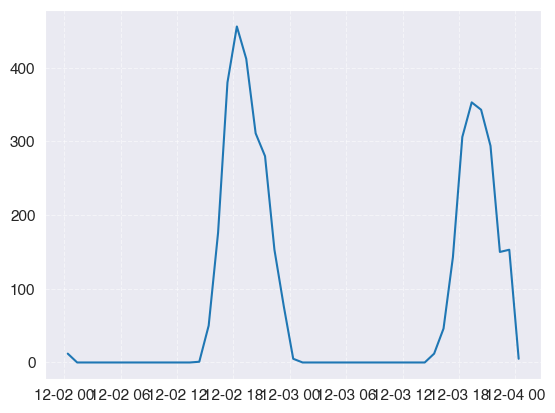

In [26]:
vrbl = col
stid = stids[0]
# for stid in stids[:2]:
    # Extract the time series
vrbl_ts = obs_df[obs_df["stid"] == stid]
ts = vrbl_ts[["solar_radiation"]]



fig1,ax1 = plt.subplots(1)
ax1.plot(ts)


ts

In [20]:
# Lat/lon of this station
obs_lat = obs.meta_df[stid].latitude
obs_lon = obs.meta_df[stid].longitude

# Get many time series of nearest points
solar_df = HRRRData.multiple_station_timeseries(fxx, {stid:(obs_lat,obs_lon)}, init_dt, "DSWRF","dswrf",)
solar_df



✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Dec-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/Users/johnlawson/PycharmProjects/UBWO3/src/hrrrdata.py:82: UserWarning: More than one time coordinate present for variable  "dswrf".
  ds = ds.metpy.parse_cf(varname=variables).squeeze().metpy.assign_y_x()


✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Dec-02 00:00 UTC F03 ┊ GRIB2 @ aws ┊ IDX @ aws


/Users/johnlawson/PycharmProjects/UBWO3/src/hrrrdata.py:82: UserWarning: More than one time coordinate present for variable  "dswrf".
  ds = ds.metpy.parse_cf(varname=variables).squeeze().metpy.assign_y_x()


✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Dec-02 00:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws


/Users/johnlawson/PycharmProjects/UBWO3/src/hrrrdata.py:82: UserWarning: More than one time coordinate present for variable  "dswrf".
  ds = ds.metpy.parse_cf(varname=variables).squeeze().metpy.assign_y_x()


✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Dec-02 00:00 UTC F09 ┊ GRIB2 @ aws ┊ IDX @ aws


/Users/johnlawson/PycharmProjects/UBWO3/src/hrrrdata.py:82: UserWarning: More than one time coordinate present for variable  "dswrf".
  ds = ds.metpy.parse_cf(varname=variables).squeeze().metpy.assign_y_x()


✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Dec-02 00:00 UTC F12 ┊ GRIB2 @ aws ┊ IDX @ aws


/Users/johnlawson/PycharmProjects/UBWO3/src/hrrrdata.py:82: UserWarning: More than one time coordinate present for variable  "dswrf".
  ds = ds.metpy.parse_cf(varname=variables).squeeze().metpy.assign_y_x()


✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Dec-02 00:00 UTC F15 ┊ GRIB2 @ aws ┊ IDX @ aws


/Users/johnlawson/PycharmProjects/UBWO3/src/hrrrdata.py:82: UserWarning: More than one time coordinate present for variable  "dswrf".
  ds = ds.metpy.parse_cf(varname=variables).squeeze().metpy.assign_y_x()


✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Dec-02 00:00 UTC F18 ┊ GRIB2 @ aws ┊ IDX @ aws


/Users/johnlawson/PycharmProjects/UBWO3/src/hrrrdata.py:82: UserWarning: More than one time coordinate present for variable  "dswrf".
  ds = ds.metpy.parse_cf(varname=variables).squeeze().metpy.assign_y_x()


✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Dec-02 00:00 UTC F21 ┊ GRIB2 @ aws ┊ IDX @ aws


/Users/johnlawson/PycharmProjects/UBWO3/src/hrrrdata.py:82: UserWarning: More than one time coordinate present for variable  "dswrf".
  ds = ds.metpy.parse_cf(varname=variables).squeeze().metpy.assign_y_x()


✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Dec-02 00:00 UTC F24 ┊ GRIB2 @ aws ┊ IDX @ aws


/Users/johnlawson/PycharmProjects/UBWO3/src/hrrrdata.py:82: UserWarning: More than one time coordinate present for variable  "dswrf".
  ds = ds.metpy.parse_cf(varname=variables).squeeze().metpy.assign_y_x()


✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Dec-02 00:00 UTC F27 ┊ GRIB2 @ aws ┊ IDX @ aws


/Users/johnlawson/PycharmProjects/UBWO3/src/hrrrdata.py:82: UserWarning: More than one time coordinate present for variable  "dswrf".
  ds = ds.metpy.parse_cf(varname=variables).squeeze().metpy.assign_y_x()


✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Dec-02 00:00 UTC F30 ┊ GRIB2 @ aws ┊ IDX @ aws


/Users/johnlawson/PycharmProjects/UBWO3/src/hrrrdata.py:82: UserWarning: More than one time coordinate present for variable  "dswrf".
  ds = ds.metpy.parse_cf(varname=variables).squeeze().metpy.assign_y_x()


✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Dec-02 00:00 UTC F33 ┊ GRIB2 @ aws ┊ IDX @ aws


/Users/johnlawson/PycharmProjects/UBWO3/src/hrrrdata.py:82: UserWarning: More than one time coordinate present for variable  "dswrf".
  ds = ds.metpy.parse_cf(varname=variables).squeeze().metpy.assign_y_x()


✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Dec-02 00:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


/Users/johnlawson/PycharmProjects/UBWO3/src/hrrrdata.py:82: UserWarning: More than one time coordinate present for variable  "dswrf".
  ds = ds.metpy.parse_cf(varname=variables).squeeze().metpy.assign_y_x()


✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Dec-02 00:00 UTC F39 ┊ GRIB2 @ aws ┊ IDX @ aws


/Users/johnlawson/PycharmProjects/UBWO3/src/hrrrdata.py:82: UserWarning: More than one time coordinate present for variable  "dswrf".
  ds = ds.metpy.parse_cf(varname=variables).squeeze().metpy.assign_y_x()


✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Dec-02 00:00 UTC F42 ┊ GRIB2 @ aws ┊ IDX @ aws


/Users/johnlawson/PycharmProjects/UBWO3/src/hrrrdata.py:82: UserWarning: More than one time coordinate present for variable  "dswrf".
  ds = ds.metpy.parse_cf(varname=variables).squeeze().metpy.assign_y_x()


✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Dec-02 00:00 UTC F45 ┊ GRIB2 @ aws ┊ IDX @ aws


/Users/johnlawson/PycharmProjects/UBWO3/src/hrrrdata.py:82: UserWarning: More than one time coordinate present for variable  "dswrf".
  ds = ds.metpy.parse_cf(varname=variables).squeeze().metpy.assign_y_x()


✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Dec-02 00:00 UTC F48 ┊ GRIB2 @ aws ┊ IDX @ aws


/Users/johnlawson/PycharmProjects/UBWO3/src/hrrrdata.py:82: UserWarning: More than one time coordinate present for variable  "dswrf".
  ds = ds.metpy.parse_cf(varname=variables).squeeze().metpy.assign_y_x()


,SURC2
2023-12-02 00:00:00+00:00,0.0
2023-12-02 03:00:00+00:00,0.0
2023-12-02 06:00:00+00:00,0.0
2023-12-02 09:00:00+00:00,0.0
2023-12-02 12:00:00+00:00,0.0
2023-12-02 15:00:00+00:00,69.2
2023-12-02 18:00:00+00:00,442.1
2023-12-02 21:00:00+00:00,148.4
2023-12-03 00:00:00+00:00,0.0
2023-12-03 03:00:00+00:00,0.0


(<Figure size 2400x1600 with 1 Axes>, <Axes: >)

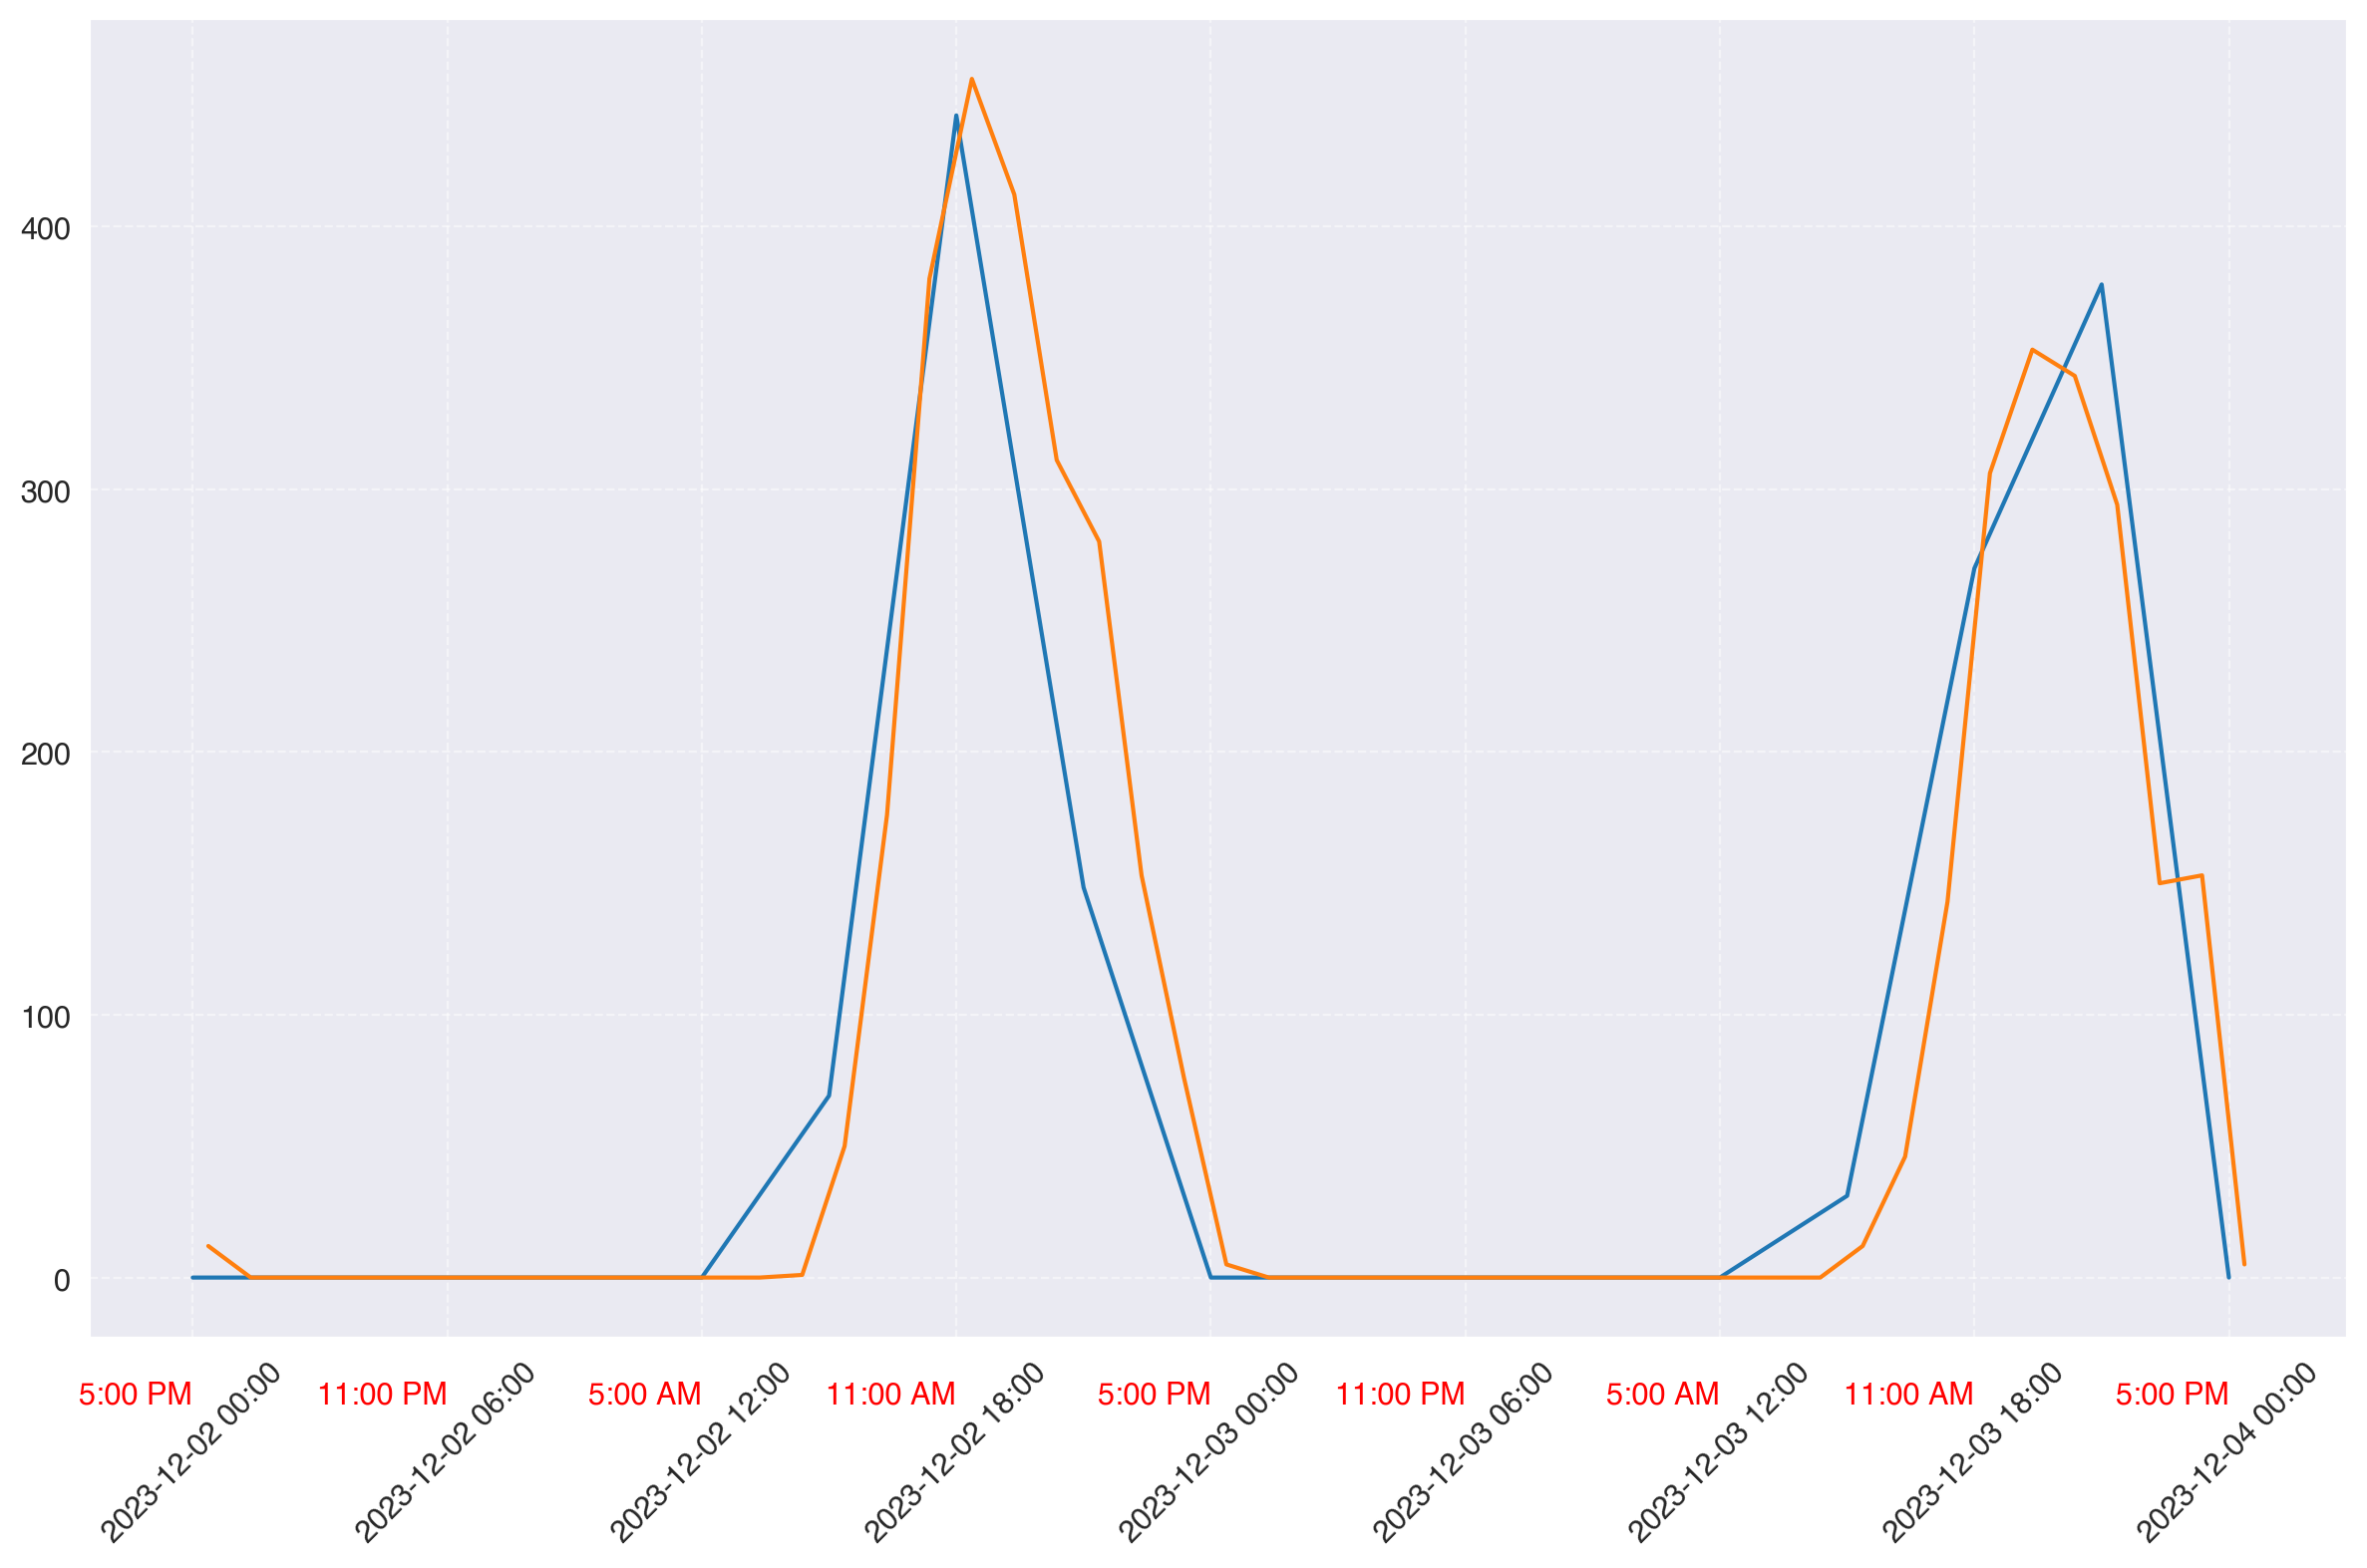

In [21]:
# Plot together
# ax1.plot(solar_df)

# Could consider plotting third line of estimated maximum, and do day's integrated W/m2 as percent

plotting.plot_meteogram(solar_df, stid, title=None, second_df=ts, second_col="solar_radiation")


In [22]:
def select_nearest_neighbours(source_df, target_df, max_diff='30min'):
    # target_df.index is a DatetimeIndex
    target_datetimes = target_df.index

    # Initialize a list to store the nearest neighbours
    nearest_indices = []

    for target in target_datetimes:
        # Wrap the target in a list and find the index of the nearest neighbour in source_df
        nearest_idx_array = source_df.index.get_indexer([target], method='nearest')
        nearest_idx = nearest_idx_array[0]  # Get the first (and only) element
        nearest_datetime = source_df.index[nearest_idx]

        # Check the time difference
        time_diff = abs(nearest_datetime - target)
        if time_diff > pd.Timedelta(max_diff):
            raise ValueError(f"Time difference exceeded: {time_diff} between {nearest_datetime} and {target}")

        nearest_indices.append(nearest_idx)

    # Select the corresponding rows from the source DataFrame
    selected_rows = source_df.iloc[nearest_indices]
    return selected_rows

# solar_df is forecast data 
# ts is obs data 

# Get closest observation to each time 
obs_ts = select_nearest_neighbours(ts, solar_df)
obs_ts

,solar_radiation
date_time,
2023-12-02 00:22:00+00:00,12.0
2023-12-02 03:22:00+00:00,0.0
2023-12-02 06:22:00+00:00,0.0
2023-12-02 09:22:00+00:00,0.0
2023-12-02 12:22:00+00:00,0.0
2023-12-02 15:22:00+00:00,50.0
2023-12-02 18:22:00+00:00,456.0
2023-12-02 21:22:00+00:00,280.0
2023-12-03 00:22:00+00:00,5.0


(<Figure size 2400x1600 with 1 Axes>, <Axes: >)

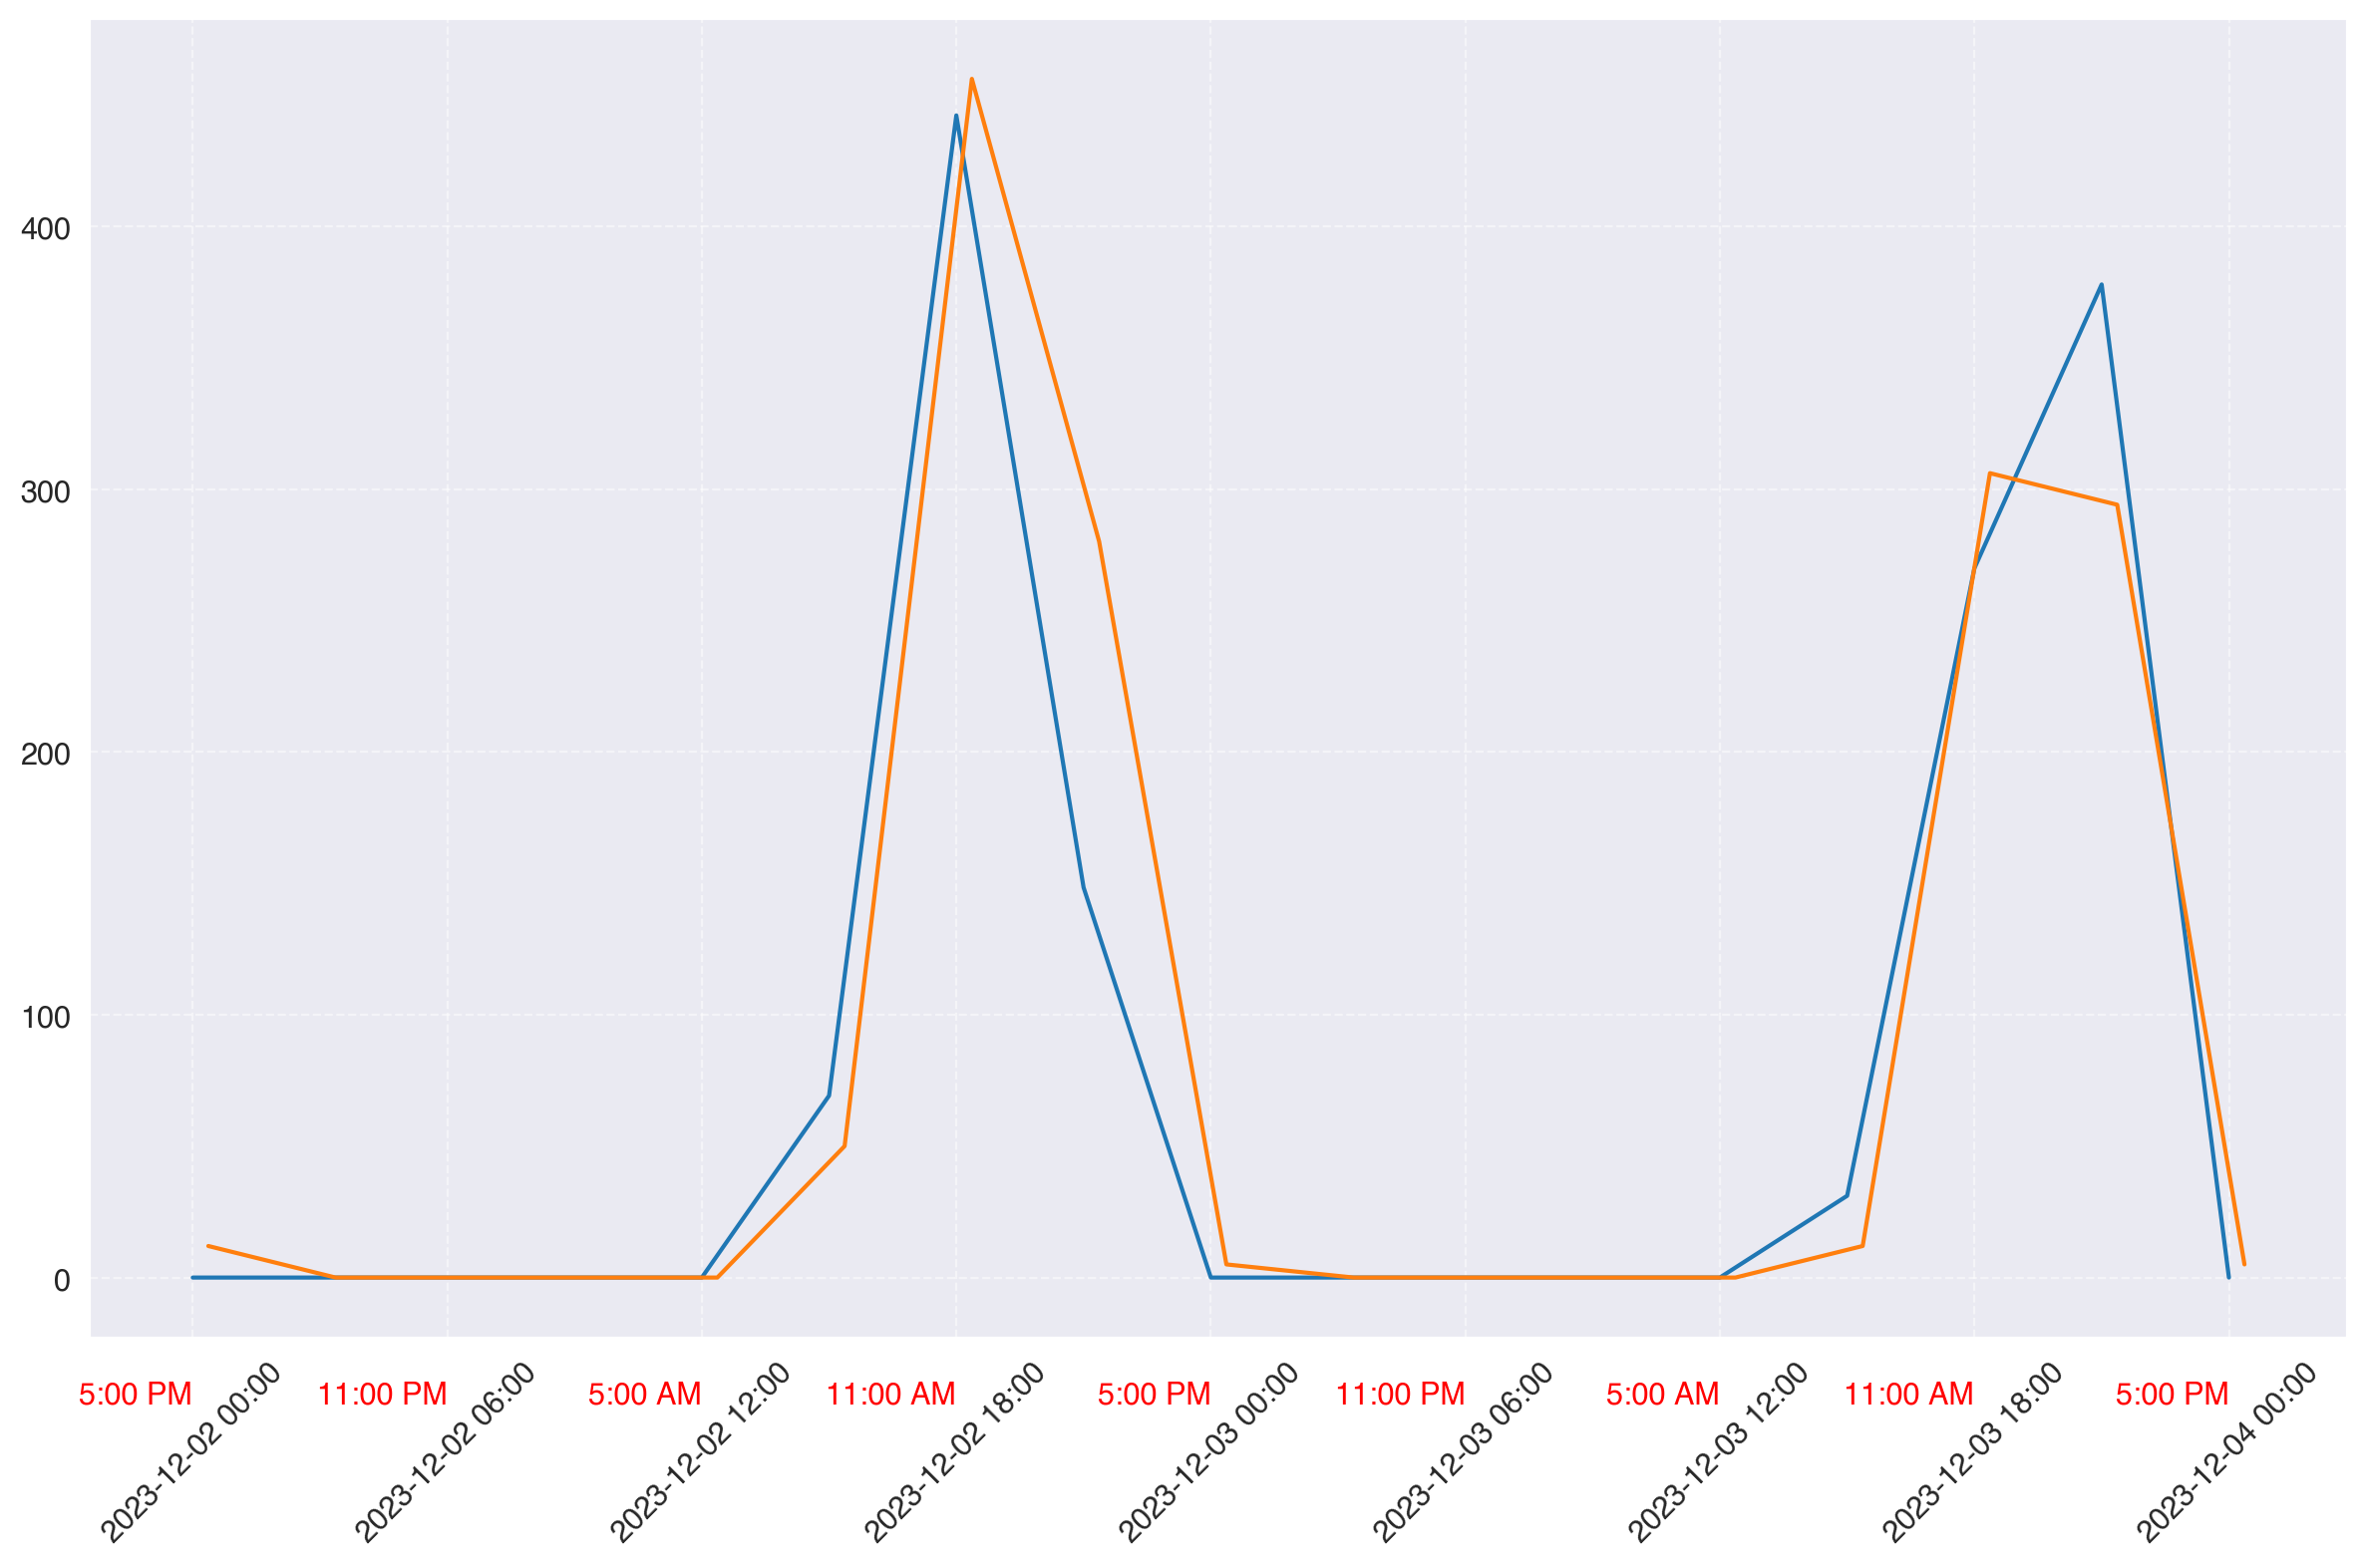

In [23]:
# Just for naming - 
fcst_ts = solar_df.rename(columns={stid:"solar_radiation"})

# this is silly to fit with plot_meteogram()'s need for dataframes 
# Now we can plot the quantised version to be fair 

# BLUE IS FORECAST
# ORANGE IS OBS 
plotting.plot_meteogram(solar_df[[stid]], stid, title=None, save=None,second_df=obs_ts, second_col="solar_radiation")

# Want to add vertical lines and slightly colour code the days 0700 to 0700 (UTC, white labels)?

In [25]:
import pandas as pd
import numpy as np

# fcst_np = fcst_ts[stid].to_numpy()
# obs_np = obs_ts["solar_radiation"].to_numpy()
fcst_np = fcst_ts.copy() 
obs_np = obs_ts.copy()

def calculate_rmse(observed, predicted):
    observed = np.array(observed)
    predicted = np.array(predicted)
    return np.sqrt(((predicted - observed) ** 2).mean())

def calculate_mae(observed, predicted):
    observed = np.array(observed)
    predicted = np.array(predicted)
    return np.abs(predicted - observed).mean()

def calculate_mbe(observed, predicted):
    observed = np.array(observed)
    predicted = np.array(predicted)
    return (predicted - observed).mean()

def adjust_date_for_custom_daily_period(dt):
    if dt.hour < 7:
        return dt.date() - pd.Timedelta(days=1)
    else:
        return dt.date()

def daily_evaluation(df_forecast, df_observed, metric_func):
    df_forecast = df_forecast.copy()
    df_observed = df_observed.copy()

    df_forecast['Adjusted_Date'] = df_forecast.index.map(adjust_date_for_custom_daily_period)
    df_observed['Adjusted_Date'] = df_observed.index.map(adjust_date_for_custom_daily_period)

    grouped_forecast = df_forecast.groupby('Adjusted_Date')
    grouped_observed = df_observed.groupby('Adjusted_Date')

    results = []
    for adjusted_date, forecast_group in grouped_forecast:
        if adjusted_date in grouped_observed.groups:
            observed_group = grouped_observed.get_group(adjusted_date)
            metric_score = metric_func(observed_group["solar_radiation"], forecast_group['solar_radiation'])
            results.append({'Date': adjusted_date, 'Score': metric_score})

    return pd.DataFrame(results)

def concatenate_metrics(dfs, metric_names):
    # Assuming dfs is a list of DataFrames and metric_names is a list of column names
    for df, name in zip(dfs, metric_names):
        df.rename(columns={'Score': name}, inplace=True)

    # Merge the DataFrames on the 'Date' column
    merged_df = pd.concat(dfs, axis=1)
    # Removing duplicate 'Date' columns
    merged_df = merged_df.loc[:,~merged_df.columns.duplicated()]

    return merged_df

# Example usage: rmse_scores = daily_evaluation(fcst_ts, obs_ts, calculate_rmse)
# print(fcst_np)
# print(obs_np)

rmse_scores = daily_evaluation(fcst_np, obs_np, calculate_rmse)
mae_scores = daily_evaluation(fcst_np, obs_np, calculate_mae)
mbe_scores = daily_evaluation(fcst_np, obs_np, calculate_mbe)



metrics_dfs = [rmse_scores, mae_scores, mbe_scores]
metric_names = ['RMSE', 'MAE', 'MBE']
concatenated_metrics_df = concatenate_metrics(metrics_dfs, metric_names)
concatenated_metrics_df



,Date,RMSE,MAE,MBE
0,2023-12-01,6.928203,4.000000,-4.000000
1,2023-12-02,47.309369,21.212500,-16.412500
2,2023-12-03,38.128486,24.016667,10.283329


In [ ]:
_# Let's do the same with GEFS for one time, 30 member for the cell (over Ouray?) 
# Plot elevation for those eight grid calls for GEFS   

In [1]:
for fx in fxx:
    for location, (lat,lon) in lat_lon.items():
        # if long_only is False:
            # meteo_init = HRRRData.determine_latest_hrrr(long_only=True)
        meteo_init = init_dt
        print("Doing meteogram starting", utils.pd_from_datetime(meteo_init))
        # fcst_hrs = list(range(0,49,1))
        fcst_hrs = list(range(0,19,2))
        valid_times = [meteo_init + datetime.timedelta(hours=h) for h in fcst_hrs]
    
        lon, lat = lat_lon[location]
    
        # Can estimate max incoming solar for these times
        df_max = derive.max_solar_radiation(valid_times, lat, lon, elevations[location])
        pass
    
        # Solar incoming forecast
        solar_ts = HRRRData.generate_timeseries(fcst_hrs, meteo_init, "DSWRF","dswrf", lat, lon)
        df = pd.DataFrame({"dswrf":solar_ts},index=valid_times)
    
        title = utils.create_meteogram_title(
                    "Incoming short-wave (W/m2)", meteo_init,"HRRR", location)
        plotting.plot_meteogram(df,"dswrf", title=title,
                                                second_df=df_max, second_col="dswrf_max")

NameError: name 'fxx' is not defined